# 💳 Fraud Detection Project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Load dataset
data = pd.read_csv(r"C:\Users\anime\Downloads\fraud_dataset\AIML Dataset.csv")
data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Data info and overview
print(data.info())
print(data.describe())
print(data.isnull().sum())
print(data['isFraud'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04

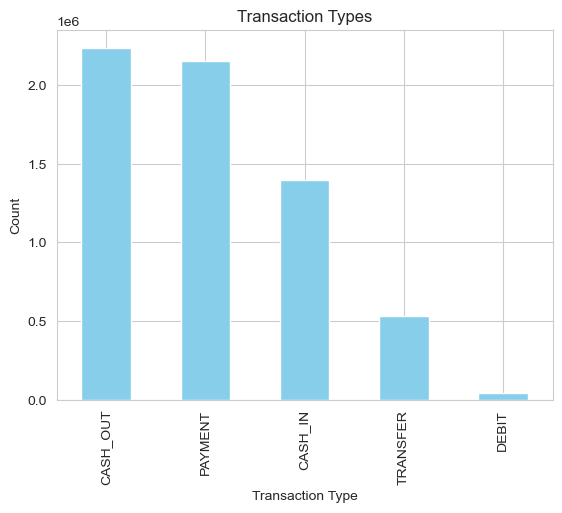

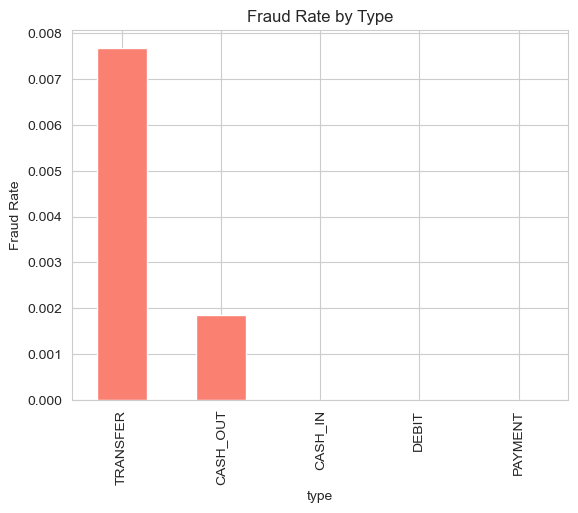

In [4]:
# Visualization
data['type'].value_counts().plot(kind='bar', color='skyblue', title='Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

fraud_by_type = data.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_by_type.plot(kind='bar', color='salmon', title='Fraud Rate by Type')
plt.ylabel('Fraud Rate')
plt.show()

In [5]:
# Feature engineering
data['balanceDiffOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balanceDiffDest'] = data['newbalanceDest'] - data['oldbalanceDest']

# Drop unnecessary columns
data_model = data.drop(['nameOrig','nameDest','isFlaggedFraud','step'], axis=1)


In [6]:
# Model training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

categorical = ['type']
numerical = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

X = data_model.drop('isFraud', axis=1)
y = data_model['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(drop='first'), categorical)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('Accuracy:', model.score(X_test, y_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786

[[1805581  100741]
 [    151    2313]]
Accuracy: 0.9471433675645148


In [7]:
# Save model
import joblib
joblib.dump(model, 'fraud_detection_pipeline.pkl')
print("✅ Model saved as fraud_detection_pipeline.pkl")

✅ Model saved as fraud_detection_pipeline.pkl


In [9]:
%%writefile fraud_detection_app.py
import streamlit as st
import pandas as pd
import joblib

st.title("💳 Fraud Detection Prediction App")
model = joblib.load('fraud_detection_pipeline.pkl')

st.markdown("Enter transaction details and click **Predict** to detect possible fraud.")

type_ = st.selectbox('Transaction Type', ['PAYMENT','TRANSFER','CASH_OUT','DEBIT','CASH_IN'])
amount = st.number_input('Amount', min_value=0.0, value=1000.0)
oldbalanceOrg = st.number_input('Old Balance (Sender)', min_value=0.0, value=10000.0)
newbalanceOrig = st.number_input('New Balance (Sender)', min_value=0.0, value=9000.0)
oldbalanceDest = st.number_input('Old Balance (Receiver)', min_value=0.0, value=0.0)
newbalanceDest = st.number_input('New Balance (Receiver)', min_value=0.0, value=0.0)

if st.button('Predict'):
    input_data = pd.DataFrame([{ 
        'type': type_, 'amount': amount,
        'oldbalanceOrg': oldbalanceOrg, 'newbalanceOrig': newbalanceOrig,
        'oldbalanceDest': oldbalanceDest, 'newbalanceDest': newbalanceDest
    }])
    prediction = model.predict(input_data)[0]
    if prediction == 1:
        st.error('🚨 This transaction **can be fraud**!')
    else:
        st.success('✅ This transaction looks legitimate.')

st.divider()
st.caption('Fraud Detection Model | Built with Streamlit & Scikit-learn')

Writing fraud_detection_app.py
